# Statement analysis in Russian using LSTM and W2V

Будем считать на видиокарте - не будем, у нас не Nvidia

In [2]:
import os
os.environ['THEANO_FLAGS'] = "device=cuda, force_device=True, floatX=float64"

import theano
print(theano.config.device, theano.config.floatX)

cuda float64


Загрузим датасет твитов на русском с http://study.mokoron.com/

In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
 
''' 
# Обучим модель W2V
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

data = gensim.models.word2vec.LineSentence('tweets.txt')
w2v_model = Word2Vec(data, size=200, window=5, min_count=3, workers=multiprocessing.cpu_count())            
'''

# Предобученная модель   
w2v_model = Word2Vec.load('w2v/tweets_model.w2v')

# Размерность
w2v_model.vector_size

200

Функция визуализации слов в пространстве *w2v*

In [2]:
def tsne_plot(labels, tokens, classes, clusters):
    tsne_model = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=33)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []

    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    colors = cm.rainbow(np.linspace(0, 1, num=clusters))

    plt.figure(figsize=(16, 9))
    
    for i in range(len(x)):
        plt.scatter(x[i], y[i], c=[colors[classes[i]]], alpha=0.75)
        plt.annotate(labels[i], alpha=0.75, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.grid(True)
    #plt.show()

Выведем для примера по 10 синонимов для каждого из  8 слов

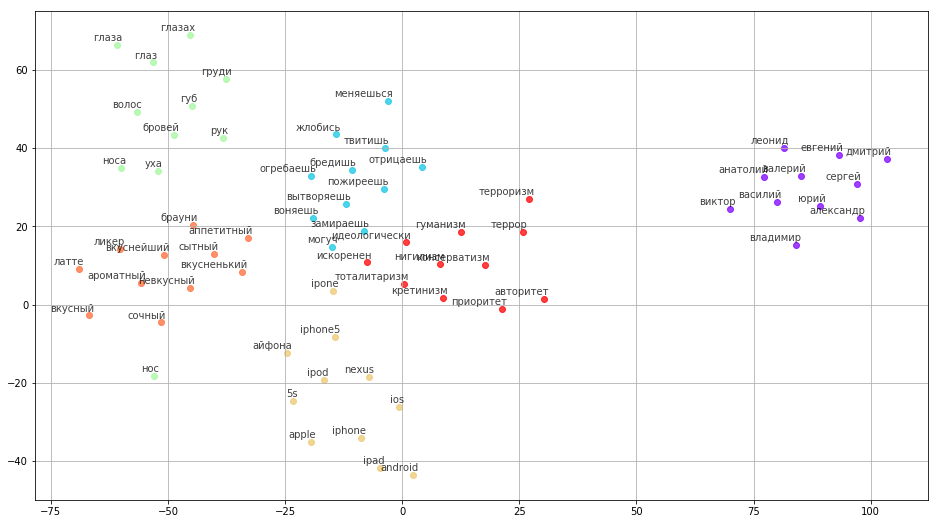

In [3]:
labels = []
tokens = []
classes = []

samples = 8
for i, word in enumerate(['виктор', 'прaвый', 'воняешь', 'F#ошибка', 'глаз', 'iphone', 'вкусный', 'нигилизм']):
    if word not in w2v_model.wv.vocab:
        continue
    tokens.append(w2v_model.wv[word])
    labels.append(word)
    classes.append(i)
    for similar_word, similarity in w2v_model.wv.most_similar(word, topn=10):
        tokens.append(w2v_model.wv[similar_word])
        labels.append(similar_word)
        classes.append(i)
        

tsne_plot(labels, tokens, classes, samples)

### Загрузим данные из датасета

В файлах хранятся размеченные твиты, нас интресует только текст

In [4]:
import pandas as pd
import numpy as np

n = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faworite', 'stcount', 'followers', 'friends', 'listcount']
data_positive = pd.read_csv('data/positive.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])
data_negative = pd.read_csv('data/negative.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])

sample_size = min(data_positive.shape[0], data_negative.shape[0])
raw_data = np.concatenate((data_positive['text'].values[:sample_size],
                           data_negative['text'].values[:sample_size]), axis=0)

labels = [1] * sample_size + [0] * sample_size

### Отфильтруем данные

* заменим ё на е  
* приведем все к нижнему регистру  
* удалим знаки препинания (вообще говоря, нужно не все) 
* ссылки заменим на тег <\url>
* упоминния пользователей заменим на тег <\user> 
    

In [5]:
import re

def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

processed_data = [preprocess_text(t) for t in raw_data]

Разделим данные на обучающую и тестовую выборки в соотношении 4/1

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(processed_data, labels, test_size=0.2, random_state=2)

Переведем предложения в вектора слов

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

DIM = w2v_model.vector_size
SENTENCE_LENGTH = 33
NUM = 100000

def get_sequences(tokenizer, x):
    sequences = tokenizer.texts_to_sequences(x)
    return pad_sequences(sequences, maxlen=SENTENCE_LENGTH)

tokenizer = Tokenizer(num_words=NUM)
tokenizer.fit_on_texts(x_train)

x_train_seq = get_sequences(tokenizer, x_train)
x_test_seq = get_sequences(tokenizer, x_test)

Using TensorFlow backend.


### Построение модели

In [8]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, LSTM, Dropout
from keras.layers import SpatialDropout1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Создаем сеть
model = Sequential()
model.add(Embedding(NUM, DIM, input_length=SENTENCE_LENGTH, mask_zero=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3, activation='relu'))
model.add(Dense(1, activation="sigmoid"))

# Копмилируем модель
model.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['binary_accuracy', 'mae'])

# Определим коллбэки для эффекивного обучения
checkpoint = ModelCheckpoint("frozen-model.hdf5", monitor='val_binary_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.9, patience=25, min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor='val_binary_accuracy', min_delta=0, patience=0, verbose=1)

### Обучение модели

In [9]:
# Гиперпараметры
NUM_EPOCHS = 3
BATCH_SIZE = 1024

In [10]:
# Обучаем модель
history = model.fit(x_train_seq, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_split=0.25,
                    verbose=1,
                    shuffle=True,
                    callbacks = [checkpoint, reduce_lr])

Train on 134307 samples, validate on 44769 samples
Epoch 1/3
134307/134307 [==============================] - 225s 2ms/step - loss: 0.5221 - binary_accuracy: 0.7334 - mean_absolute_error: 0.3555 - val_loss: 0.4611 - val_binary_accuracy: 0.7775 - val_mean_absolute_error: 0.3119

Epoch 00001: val_binary_accuracy improved from -inf to 0.77748, saving model to frozen-model.hdf5
Epoch 2/3
134307/134307 [==============================] - 215s 2ms/step - loss: 0.3644 - binary_accuracy: 0.8381 - mean_absolute_error: 0.2315 - val_loss: 0.4716 - val_binary_accuracy: 0.7756 - val_mean_absolute_error: 0.2822

Epoch 00002: val_binary_accuracy did not improve from 0.77748
Epoch 3/3
134307/134307 [==============================] - 213s 2ms/step - loss: 0.2658 - binary_accuracy: 0.8876 - mean_absolute_error: 0.1639 - val_loss: 0.5608 - val_binary_accuracy: 0.7636 - val_mean_absolute_error: 0.2704

Epoch 00003: val_binary_accuracy did not improve from 0.77748


### Выведем статистику обучения

Populating the interactive namespace from numpy and matplotlib


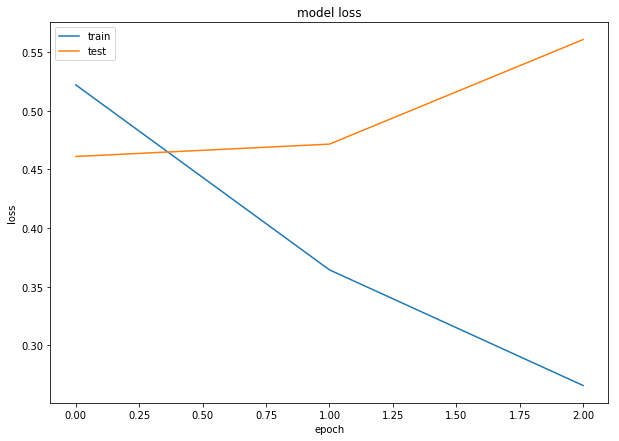

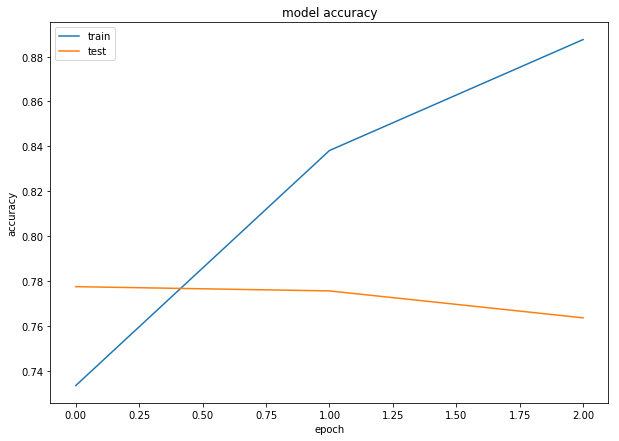

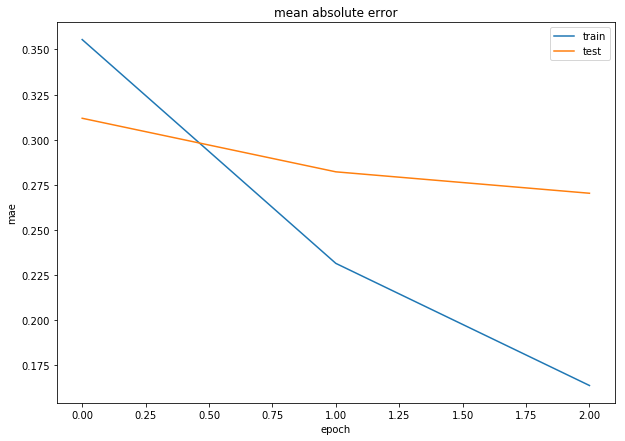

In [11]:
import matplotlib.pylab as plt
import matplotlib.pyplot as plt

%pylab inline
plt.figure(figsize(10,7))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()


plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('mean absolute error')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [12]:
# Проверяем качество обучения на тестовых данных
scores = model.evaluate(x_test_seq, y_test, batch_size=BATCH_SIZE)

print("Точность на тестовых данных: %.2f%%" % (scores[1] * 100))

44770/44770 [==============================] - 15s 339us/step
Точность на тестовых данных: 76.15%


In [13]:
scores

[0.5622868276292095, 0.7614697346070635, 0.2727495604922576]

### Примеры работы

Обычные высказывания

In [14]:
s0 = 'Вообще говоря, мне не по душе этот момент. Ужасно тормозит. стоит дохрена!!! Зря выкинул деньги'
s1 = 'Если немного дорабоать, полчится достойная альтернатива iphone'
s2 = 'Кусь. Фиговая фигня, но я балдею'
s3 = 'Крч, fuck u gays!!!'
s4 = 'Ничего не понятно, но в целом неплохо('
s5 = 'Когда я первый раз зашел домой, я обрадовался столь плохому освещению'

statements = list([s0, s1, s2, s3, s4, s5])

filterd_statements = [preprocess_text(t) for t in statements]
statements_seq = get_sequences(tokenizer, filterd_statements)

In [15]:
pred = model.predict(statements_seq)

In [16]:
np.set_printoptions(precision=2)
for t in pred:
    print(t)

[0.02]
[1.]
[0.41]
[0.04]
[0.66]
[0.37]


### Примеры отзывов на приложенеие "Мегафон" из Google Play

In [17]:
m0 = 'глюкопрога ничего не решает, пишет ошибка.'
m1 = 'Не могу зайти в личный кабинет,30минут ждала пока загрузится,так и не звгрузился!!!!!'
m2 = '''С сегодняшнего дня приложение просто перестало работать. 
Оператор выслал ссылку по ней все работает. Пробовал переустановить приложение, без результатов.'''

m3 = '''верните иконки(виджеты) чтоб можно было вывести на главный экран телефона, 
очень удобно следить за балансом, и остатком трафика и т.д. не нужно постоянно заходить в личный кабинет. 
уважаемые разработчики а можно что бы виджеты работали на старых телефонах? у меня один из телефонов андройд 4.2.2. 
спасибо запонимание.(большая аудитория).у кого дорогие старые телефоны.'''

m4 = '''По работе приложения вопросов нет. Перешел на МегаФон с Билайна. 
И там и там использовал тарифный план с включенными пакетами услуг. 
И вот на мегафоне решили сделать гениально. Пока есть пакет минут, звонки на все номера (в том числе и мегафон)
списываются с пакета включенных минут. А вот когда пакет заканчивается, пожалуйста, звоните на мегафон бесплатно. 
В качестве информации: на Билайне пакет минут расходуется, только, на разговоры с другими операторами. 
Пожалел о переходе в первый же день!!!'''

m5 = 'ну конечно я не собиралась пистаь этот отзыв но все-таки удобная прога ставлю пять звезд'

In [18]:
statements = list([m0, m1, m2, m3, m4, m5])

filterd_statements = [preprocess_text(t) for t in statements]
statements_seq = get_sequences(tokenizer, filterd_statements)

In [19]:
pred = model.predict(statements_seq)
for t in pred:
    print(t)

[0.05]
[0.65]
[0.01]
[0.99]
[0.24]
[0.9]
